# Sommaire
* 1 Principes et démarche
* 2 Image préparation et augmentation
* 3 Modèle SIFT-Classification
* 4 Modèle CNN Personnel
* 5 Modèle CNN Transfer Learning


----------------

# 1 Principes et démarche

## 1.1 Challenges

### Classification des chiens
La classification des chiens est rendue particulièrement difficile par des variations dans certains cas :
* Faibles entre 2 races (différentes races de Terrier par exemple)
* Fortes entre des chiens d'une même race

Cela nécessite une approche spécifique pour être suffisamment performante, au delà d'une classification classique, telle qu'elle peut être réalisée pour le jeu de données MNIST(chiffres manuscrits).

Des méthodes utilisant des descripteurs SIFT ou des CNN (Convolutional Neural Network) seront mises en oeuvre.


### Taille limité du jeu de Training (100 images par classe)
Le nombre réduit d'images par race (classe) rend encore plus difficile le challenge, et nécessite donc une attention particulière en mettant en ouvre des approches optimisées :
* Par une "image augmentation", en générant d'autres images à partir du jeu d'images Train, et ainsi en augmentant artificiellement la taille du jeu d'images en entrée
* Par une capitalisation de paramètres entraînés sur des données plus larges = "Transfer learning"


### Maîtrise de l'overfitting et optimisation des hyperparamètres
En particulier pour les CNN, le risque d'overfitting est important, les paramètres optimisés avec le jeu de Training risquent de ne pas être performants pour le jeu de Test.

Dans ce cadre plusieurs actions seront mises en oeuvre :
* Utilisation d'une approche GridsearchCV dès que possible pour à la fois effectuer des cross-validations et optimiser les hyperparamètres
* Pour optimiser le nombre d'epochs en CNN, séparer le fichier d'entraînement en 2 = fichier Train et fichier Validation (indépendamment du fichier Test), afin d'optimiser cet hyperparamètre en fonction du score du fichier Validation



## 1.2 Démarche proposée

### Principes
Nous proposons une démarche structurée en 4 étapes principales :
* Un pré-processing des images, incluant de "l'image augmentation", qui sera utilisé en entrée des 3 modélisations
* Une modélisation basée sur du SIFT / classification 
* Une modélisation basée sur un réseau de neurones CNN construit ex-nihilo qui sera dénomé "CNN perso"
* Une modélisation basée sur un réseau de neurones CNN, par "Transfer learning" d'un réseau pré-entrainé sur un jeu d'images plus important

Chaque étape est réalisée dans un NoteBook spécifique.


### Nombre de classes limité à 2
Le nombre de classes a été volontairement limité à 2 (classification 0/1), afin de permettre des temps de traitement raisonnables, en particulier pour la modélisation "CNN perso"




-------------

# 2. Image préparation et augmentation

* 2.1 Récupération des données et préparation
* 2.2 Image augmentation du fichier Train (création images)
* 2.3 Image optimisation du fichier Test (bounding box)
* 2.4 Création de matrices Train et Test (pour CNN et ImageDataGenerator Keras)
* 2.5 Image augmentation Train via Keras (matrices - ImageDataGenerator)


## Principes

Différentes approches ont été implémentées afin d'optimiser le jeu d'images disponible :

<b>Bounding box Train :</b> 
* Utilisation des données "annotations" pour récupérer les coordonnées du cadre entourant les chiens, et cropping (zoom) de l'image sur ce cadre

<b>Mirroring Train :</b>
* Transformation des images Train (standards et bounding box) en mirroir (horizontal flip) et ajout au jeu de données Train

<b>Cropping center Train :</b>
* Zoom des images Train, identique à chaque image (pas forcément centré sur le chien, mais hypothèse que souvent les images des chiens sont relativement cetrées sur eux) => complémentaire à un cropping "bounding box"

<b>Data generator Keras :</b>
* A partir de l'ensemble des images Train précédentes (200 * 5 = 1000 pour 2 classes), génération d'un jeu de 1000 images Train supplémentaire, selon différentes transformations réalisées aléatoirement)
* Cette génération est faite une fois et sauvegardées, afin d'obtenir le même jeu Train pour tous les modèles y compris SIFT (sinon possibilité de générer à la volée ces images lors d'un "fit" d'un modèle CNN)

<b>Image Equalization (gray) :</b>
* "Equalization" des images Train transformées en gris, pour un meilleur contraste des images
* Cette "Equalization" sera implémentée à la volée pour le modèle SIFT et comparée avec une approche sans "Equalization"

<b>Bounding box Test : </b>
* Détermination de la bounding box de chaque image Test(pas disposible dans le fichier Test)
* Les résultats seront comparés pour le modèle SIFT avec une approche avec les images Test standards




---------------

## 2.1 Récupération des données et préparation

### Contenu des fichiers

<b>Fichier Train</b>

Un fichier .mat (MatLab) contient 4 sous-fichiers contenant chacun :
* Images Train : liens vers les images, classées par race (1 sous-dossier par race)
* Labels Train : labels de classe associés, pour déterminer la race
* Annotations Train : liens vers fichier annotation XML de chaque image (contient princialement les coordonnées de la bounding box centrée sur le chien)
* Histograms : lien vers les fichiers MatLab histogrammes (non exploité)


<b>Fichier Test</b>

Un fichier .mat (MatLab) contient 2 sous-fichiers contenant chacun :
* Images Test : liens vers les images, classées par race (1 sous-dossier par race)
* Labels Test : labels de classe associés, pour déterminer la race

Les bounding box ne sont pas disponibles pour le fichier Test


### Actions
* Récupération des fichiers MatLab Train et Test
* Découpage en groupes de données
* Affichage des données
* Stockage des données


In [0]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import cv2 as cv


### Récupération des fichiers MatLab Train et Test

In [0]:
# Récupération des fichiers MatLab Train et Test

path_Dogs = "D:/ML_Datasets/Images/Dogs/"
mat_Train = scipy.io.loadmat(path_Dogs + 'train_data.mat')
mat_Test = scipy.io.loadmat(path_Dogs + 'test_data.mat')

print(mat_Test)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Mar 28 12:07:09 2012', '__version__': '1.0', '__globals__': [], 'test_info': array([[ (array([[array(['n02085620-Chihuahua/n02085620_2650.jpg'],
      dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_4919.jpg'],
      dtype='<U38')],
       [array(['n02085620-Chihuahua/n02085620_1765.jpg'],
      dtype='<U38')],
       ..., 
       [ array(['n02116738-African_hunting_dog/n02116738_3635.jpg'],
      dtype='<U48')],
       [ array(['n02116738-African_hunting_dog/n02116738_2988.jpg'],
      dtype='<U48')],
       [ array(['n02116738-African_hunting_dog/n02116738_6330.jpg'],
      dtype='<U48')]], dtype=object), array([[array(['n02085620-Chihuahua/n02085620_2650'],
      dtype='<U34')],
       [array(['n02085620-Chihuahua/n02085620_4919'],
      dtype='<U34')],
       [array(['n02085620-Chihuahua/n02085620_1765'],
      dtype='<U34')],
       ..., 
       [ array(['n02116738-African_hunting_dog/n02116738_


---

### Affichage des données

In [0]:
# Fichier Train

print("Train : ")
print("-------")
print()

print("images jpg : ")
print("------------")
image_jpg_Train = np.apply_along_axis(lambda x : x, 1, mat_Train['train_info'][0][0][0])
print(image_jpg_Train.shape)
print(image_jpg_Train[0:5])
print()

print("images labels : ")
print("------------")
image_label_Train = np.apply_along_axis(lambda x : x[0], 1, mat_Train['train_info'][0][0][2])
print(image_label_Train.shape)
print(image_label_Train[0:5])
print()

print("images annotation : ")
print("------------")
image_annotation_Train = np.apply_along_axis(lambda x : x, 1, mat_Train['train_info'][0][0][1])
print(image_annotation_Train.shape)
print(image_annotation_Train[0:5])
print()

print("images histograms spm : ")
print("------------")
image_histo_Train = np.apply_along_axis(lambda x : x, 1, mat_Train['train_info'][0][0][3])
print(image_histo_Train.shape)
print(image_histo_Train[0:5])
print()



# Fichier Test
print("---------------------------------------------------------")
print()
print("Test : ")
print("-------")
print()

print("images jpg : ")
print("------------")
image_jpg_Test = np.apply_along_axis(lambda x : x, 1, mat_Test['test_info'][0][0][0])
print(image_jpg_Test.shape)
print(image_jpg_Test[0:5])
print()

print("images labels : ")
print("------------")
image_label_Test = np.apply_along_axis(lambda x : x[0], 1, mat_Test['test_info'][0][0][2])
print(image_label_Test.shape)
print(image_label_Test[0:5])
print()



Train : 
-------

images jpg : 
------------
(12000, 1)
[[array(['n02085620-Chihuahua/n02085620_5927.jpg'],
      dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_4441.jpg'],
      dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_1502.jpg'],
      dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_1916.jpg'],
      dtype='<U38')]
 [array(['n02085620-Chihuahua/n02085620_13151.jpg'],
      dtype='<U39')]]

images labels : 
------------
(12000,)
[1 1 1 1 1]

images annotation : 
------------
(12000, 1)
[[array(['n02085620-Chihuahua/n02085620_5927'],
      dtype='<U34')]
 [array(['n02085620-Chihuahua/n02085620_4441'],
      dtype='<U34')]
 [array(['n02085620-Chihuahua/n02085620_1502'],
      dtype='<U34')]
 [array(['n02085620-Chihuahua/n02085620_1916'],
      dtype='<U34')]
 [array(['n02085620-Chihuahua/n02085620_13151'],
      dtype='<U35')]]

images histograms spm : 
------------
(12000, 1)
[[ array(['histograms_spm/n02085620-Chihuahua/n02085620_5927.mat'],
      dtype='<


-----------------------

### Analyse des fichiers histogrammes




In [0]:
# Récupération des fichier .mat de chaque histogramme



----

### Stockage des données


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_jpg_Train.py", "wb") as fp:   
    pickle.dump(image_jpg_Train, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_label_Train.py", "wb") as fp:   
    pickle.dump(image_label_Train, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_annotation_Train.py", "wb") as fp:   
    pickle.dump(image_annotation_Train, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_histo_Train.py", "wb") as fp:   
    pickle.dump(image_histo_Train, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_jpg_Test.py", "wb") as fp:   
    pickle.dump(image_jpg_Test, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_label_Test.py", "wb") as fp:   
    pickle.dump(image_label_Test, fp)



-----

# 2.2 Image augmentation du fichier Train

* 2.2.1 Préparation des chemins vers les images augmentées et des labels associés
* 2.2.2 Création des Images redimensionnées et augmentées


In [0]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import cv2 as cv


In [0]:
import pickle

# Train
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_jpg_Train.py", "rb") as fp:   # Unpickling
    image_jpg_Train = pickle.load(fp)
      
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_label_Train.py", "rb") as fp:   # Unpickling
    image_label_Train = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_annotation_Train.py", "rb") as fp:   # Unpickling
    image_annotation_Train = pickle.load(fp)
      
# with open("D:/ML_Datasets/Images/Dogs/Sauv/image_histo_Train.py", "rb") as fp:   # Unpickling
#     image_histo_Train = pickle.load(fp)


# Test
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_jpg_Test.py", "rb") as fp:   # Unpickling
    image_jpg_Test = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_label_Test.py", "rb") as fp:   # Unpickling
    image_label_Test = pickle.load(fp)


-----------------

## 2.2.1 Préparation des chemins vers les images augmentées et des labels associés
* Création des chemins vers les images initiales et augmentées
* Création des labels des images initiales et augmentées
* Sélection de 2 classes
* Création des chemins vers les images des 2 classes sélectionnées




-------------------------

### Création des chemins vers les images initiales (std) et augmentées (mirror, crop_center, crop_box, crop_box_mirror)

In [0]:
# Initialisation des chemins vers les images

img_dir = "D:/ML_Datasets/Images/Dogs/images/"
img_dir_std = "D:/ML_Datasets/Images/Dogs/images_std/"
img_dir_mirror = "D:/ML_Datasets/Images/Dogs/images_mirror/"
img_dir_crop_center = "D:/ML_Datasets/Images/Dogs/images_crop_center/"
img_dir_crop_box = "D:/ML_Datasets/Images/Dogs/images_crop_box/"
img_dir_crop_box_mirror = "D:/ML_Datasets/Images/Dogs/images_crop_box_mirror/"

# Train
image_Train_ini = [img_dir + f[0][0] for f in image_jpg_Train]
image_Train_std = [img_dir_std + f[0][0].split('/')[1] for f in image_jpg_Train]
image_Train_mirror = [img_dir_mirror + f[0][0].split('/')[1] for f in image_jpg_Train]
image_Train_crop_center = [img_dir_crop_center + f[0][0].split('/')[1] for f in image_jpg_Train]
image_Train_crop_box = [img_dir_crop_box + f[0][0].split('/')[1] for f in image_jpg_Train]
image_Train_crop_box_mirror = [img_dir_crop_box_mirror + f[0][0].split('/')[1] for f in image_jpg_Train]

# Test
img_dir_bounding_box_crop = "D:/ML_Datasets/Images/Dogs/images_bounding_box_crop/"

image_Test = [img_dir + f[0][0] for f in image_jpg_Test]
image_Test_bounding_box_crop = [img_dir_bounding_box_crop + f[0][0].split('/')[1] for f in image_jpg_Test]

### Création des labels des images initiales et augmentées (Train)

In [0]:
# Train
image_label_Train_std = image_label_Train
image_label_Train_mirror = image_label_Train_std
image_label_Train_crop_center = image_label_Train_std
image_label_Train_crop_box = image_label_Train_std
image_label_Train_crop_box_mirror = image_label_Train_std


### Sélection de 2 classes (2 races)

Race :  n02085620-Chihuahua
------


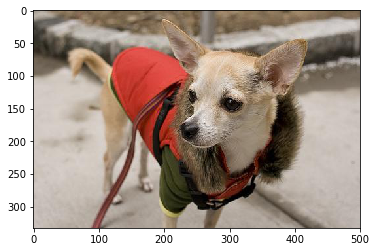


Race :  n02085782-Japanese_spaniel
------


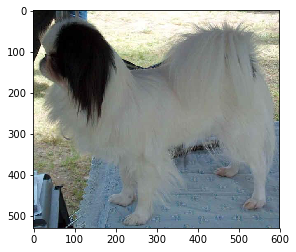

In [0]:
# Sélection de 2 classes (2 races) et affichage de limage d'un chien par classe

dog_classes = [1,2]
image_2class_Train = [image for i,image in enumerate(image_Train_ini) if image_label_Train[i] in dog_classes]

for i, dog_class in enumerate(dog_classes) :
    ind = i*100 + 2
    img_path = image_2class_Train[ind]
    print("Race : ", img_path.split('/')[5])
    print("------")
    img = cv.imread(img_path)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    print()


-----------

### Création des chemins vers les images des classes sélectionnées (Train et Test) + labels associés


In [0]:

# Train 
image_2class_Train_std = [image for i,image in enumerate(image_Train_std) if image_label_Train_std[i] in dog_classes]
image_2class_Train_mirror = [image for i,image in enumerate(image_Train_mirror) 
                                                                if image_label_Train_mirror[i] in dog_classes]
image_2class_Train_crop_center = [image for i,image in enumerate(image_Train_crop_center) 
                                                                if image_label_Train_crop_center[i] in dog_classes]
image_2class_Train_crop_box = [image for i,image in enumerate(image_Train_crop_box) 
                                                                if image_label_Train_crop_box[i] in dog_classes]
image_2class_Train_crop_box_mirror = [image for i,image in enumerate(image_Train_crop_box_mirror) 
                                                                if image_label_Train_crop_box_mirror[i] in dog_classes]

# image_2class_Train = image_2class_Train_crop_box + image_2class_Train_std

image_2class_Train_box = image_2class_Train_crop_box

image_2class_Train = image_2class_Train_std + image_2class_Train_mirror\
                                            + image_2class_Train_crop_box + image_2class_Train_crop_box_mirror

image_2class_Train_tot = image_2class_Train_std + image_2class_Train_mirror + image_2class_Train_crop_center\
                                            + image_2class_Train_crop_box + image_2class_Train_crop_box_mirror
print(len(image_2class_Train))
print(image_2class_Train[0:5])
print()

y_2class_Train_std = [label for label in image_label_Train_std if label in dog_classes]
y_2class_Train_mirror = y_2class_Train_std
y_2class_Train_crop_center = y_2class_Train_std
y_2class_Train_crop_box = y_2class_Train_std
y_2class_Train_crop_box_mirror = y_2class_Train_std

# y_2class_Train_num = y_2class_Train_crop_box + y_2class_Train_std
y_2class_Train_box_num = y_2class_Train_crop_box
y_2class_Train_num = y_2class_Train_std + y_2class_Train_mirror\
                                        + y_2class_Train_crop_box + y_2class_Train_crop_box_mirror

y_2class_Train_tot_num = y_2class_Train_std + y_2class_Train_mirror + y_2class_Train_crop_center\
                                          + y_2class_Train_crop_box + y_2class_Train_crop_box_mirror

# Label = indice dans la liste "dog_classes"
y_2class_Train = [dog_classes.index(i) for i in y_2class_Train_num]
y_2class_Train_box = [dog_classes.index(i) for i in y_2class_Train_box_num]
y_2class_Train_tot = [dog_classes.index(i) for i in y_2class_Train_tot_num]
print(len(y_2class_Train))
print(y_2class_Train[0:5])


image_2class_Test = [image for i,image in enumerate(image_Test) if image_label_Test[i] in dog_classes]
image_2class_Test_box = [image for i,image in enumerate(image_Test_bounding_box_crop) if image_label_Test[i] in dog_classes]

y_2class_Test_num = [label for label in image_label_Test if label in dog_classes]
y_2class_Test = [dog_classes.index(i) for i in y_2class_Test_num]

print()
print(image_2class_Train[-1])
print(image_2class_Test[-1])
print(len(image_2class_Train))
print(len(image_2class_Test))


800
['D:/ML_Datasets/Images/Dogs/images_std/n02085620_5927.jpg', 'D:/ML_Datasets/Images/Dogs/images_std/n02085620_4441.jpg', 'D:/ML_Datasets/Images/Dogs/images_std/n02085620_1502.jpg', 'D:/ML_Datasets/Images/Dogs/images_std/n02085620_1916.jpg', 'D:/ML_Datasets/Images/Dogs/images_std/n02085620_13151.jpg']

800
[0, 0, 0, 0, 0]

D:/ML_Datasets/Images/Dogs/images_crop_box_mirror/n02085782_2914.jpg
D:/ML_Datasets/Images/Dogs/images/n02085782-Japanese_spaniel/n02085782_3354.jpg
800
137


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Train.py", "wb") as fp:   
    pickle.dump(image_2class_Train, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Train.py", "wb") as fp:   
    pickle.dump(y_2class_Train, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Train_box.py", "wb") as fp:   
    pickle.dump(y_2class_Train_box, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Train_tot.py", "wb") as fp:   
    pickle.dump(y_2class_Train_tot, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Test.py", "wb") as fp:   
    pickle.dump(image_2class_Test, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Test_box.py", "wb") as fp:   
    pickle.dump(image_2class_Test_box, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Test.py", "wb") as fp:   
    pickle.dump(y_2class_Test, fp)



----------

## 2.2.2 Création des Images redimensionnées et augmentées (Train)

* Récupération des bounding boxes des images du fichier Train
* Création des images augmentées sur le disque (mirroring, center cropping, bounding box)
* Test "Equalization" d'images



-------------

### Fonctions de génération de nouvelles images augmentées (Train)

In [0]:
# Fonctions de génération de nouvelles images

from PIL import Image
 
def copy_std_image_fct(image_path, saved_location):
    image_obj = Image.open(image_path)
    image_obj.save(saved_location)


def mirror_image_fct(image_path, saved_location):
    image_obj = Image.open(image_path)
    rotated_image = image_obj.transpose(Image.FLIP_LEFT_RIGHT)
    rotated_image.save(saved_location)

    
def crop_center_image_fct(image_path, saved_location):
    image_obj = Image.open(image_path)
    new_width = 200
    new_height = 200
    
    width, height = image_obj.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    
    image_cropped = image_obj.crop((left, top, right, bottom))
    image_cropped.save(saved_location)

def crop_box_image_fct(image_path, image_box, saved_location, saved_location_mirror):
    image_obj = Image.open(image_path)

    left = image_box[0]
    top = image_box[1]
    right = image_box[2]
    bottom = image_box[3]
    
    image_cropped = image_obj.crop((left, top, right, bottom))
    image_cropped.save(saved_location)
    
    rotated_image = image_cropped.transpose(Image.FLIP_LEFT_RIGHT)
    rotated_image.save(saved_location_mirror)

    
# Fonction de récupération du rectangle (bounding box) qui cadre les chiens du fichier Train
from lxml import etree

def image_box_fct(annotation_path) :
    # print(annotation_path)
    annotation_xml = etree.parse(annotation_path)

    l_xmin = annotation_xml.xpath("/annotation/object/bndbox/xmin")
    xmin = int([x.text for x in l_xmin][0])

    l_ymin = annotation_xml.xpath("/annotation/object/bndbox/ymin")
    ymin = int([x.text for x in l_ymin][0])

    l_xmax = annotation_xml.xpath("/annotation/object/bndbox/xmax")
    xmax = int([x.text for x in l_xmax][0])

    l_ymax = annotation_xml.xpath("/annotation/object/bndbox/ymax")
    ymax = int([x.text for x in l_ymax][0])

    image_box = (xmin,ymin,xmax,ymax)
    # print(image_box)
    
    return image_box


### Récupération des bounding boxes des images du fichier Train

In [0]:
# Récupération des boxes
annotation_dir = "D:/ML_Datasets/Images/Dogs/annotation/"
annotation_Train = [annotation_dir + f[0][0] for f in image_annotation_Train]
print(annotation_Train[0:2])
image_box_Train = [image_box_fct(annotation_path) for annotation_path in annotation_Train]
print(image_box_Train[0:2])
print()


['D:/ML_Datasets/Images/Dogs/annotation/n02085620-Chihuahua/n02085620_5927', 'D:/ML_Datasets/Images/Dogs/annotation/n02085620-Chihuahua/n02085620_4441']
[(30, 14, 236, 298), (107, 110, 296, 401)]




-------------

### Création des images augmentées sur le disque (mirroring, center cropping, bounding box)

In [0]:
# Création des images augmentées sur le disque (mirroring, center cropping, box)

for i in range(len(images_Train_ini)) :
    image_path = images_Train_ini[i]
    saved_location_std = images_Train_std[i]
    saved_location_mirror = images_Train_mirror[i]
    saved_location_crop_center = images_Train_crop_center[i]
    saved_location_crop_box_mirror = images_Train_crop_box_mirror[i]
    image_box = image_box_Train[i]
    
    copy_std_image_fct(image_path, saved_location_std)
    mirror_image_fct(image_path, saved_location_mirror)
    crop_center_image_fct(image_path, saved_location_crop_center)
    crop_box_image_fct(image_path, image_box, saved_location_crop_box, saved_location_crop_box_mirror)


Image initiale : 
---------------


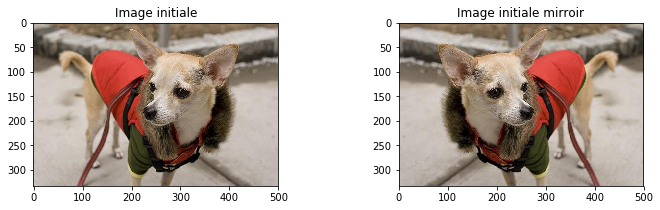


Image bounding box (fichier annotation) : 
----------------------------------------


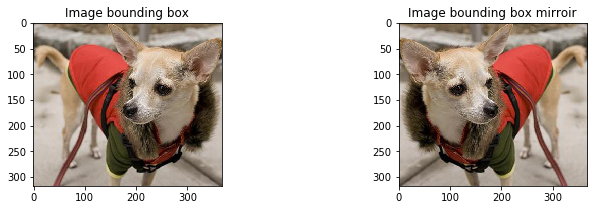

In [0]:
# Affichage d'un exemple d'images augmentées

ind = 2
fig = plt.figure(figsize=(12, 3))
print("Image initiale : ")
print("---------------")
img = cv.imread(image_Train_std[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Image initiale')
ax1.imshow(img)


img = cv.imread(image_Train_mirror[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Image initiale mirroir')
ax2.imshow(img)
plt.show()

fig = plt.figure(figsize=(12, 3))
print()
print("Image bounding box (fichier annotation) : ")
print("----------------------------------------")
img = cv.imread(image_Train_crop_box[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Image bounding box')
ax1.imshow(img)

img = cv.imread(image_Train_crop_box_mirror[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Image bounding box mirroir')
ax2.imshow(img)
plt.show()


Image cropping center : 
---------------------


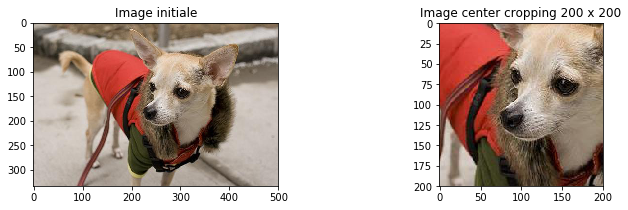

In [0]:
fig = plt.figure(figsize=(12, 3))
print()
print("Image cropping center : ")
print("---------------------")
img = cv.imread(image_Train_std[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Image initiale')
ax1.imshow(img)

img = cv.imread(image_Train_crop_center[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Image center cropping 200 x 200')
ax2.imshow(img)
plt.show()


--------------

### Test "Equalization" d'images

<b> Analyse : </b>
* Les images sont effectiveemnt améliorées en terme de contraste
* Il peut être ainsi intéressant d'exploiter cette transformation, en particulier avec le modèle SIFT, afin de détecter le maximum de descripteurs (CF NoteBook SIFT)



Race :  n02085620_1502.jpg
------


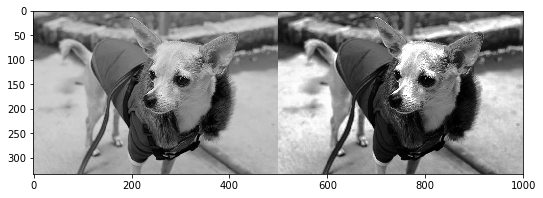

In [0]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 3))
ind = 2
img_path = image_2class_Train[ind]
print("Race : ", img_path.split('/')[5])
print("------")
img = cv.imread(img_path)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
equ = cv.equalizeHist(img)
res = np.hstack((img,equ))
plt.imshow(res, cmap=cm.gray)
plt.show()
print()



---------------------

## 2.3 Image optimisation du fichier Test (bounding box)

### Principe
* Utilisation d'un modèle pré-entrainé pour détecter les bounding box de chien sur les images (Transfer learning)
* Modèle = MobileNet SSD, via un modèle Caffe sérialisé


### Fonction de détermination des Bounding box des images Test - et sauvegarde des images croppées sur la bounding box

In [0]:
# Détection d'objet, ciblé sur "Dog"
# Tranfert learning - Utilisation de MobileNetSSD (model caffe) pour détecter les bounding box de type "Dog"

import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import cv2 as cv
from PIL import Image

# Path du model caffe utilisé (transfer learning)
args_prototxt_path = "C:/Users/Dom/0.ML_Exos_Python/0. Parcours_DataScientist/DS_Projet_7_Image_Indexation/object-detection-deep-learning/MobileNetSSD_deploy.prototxt.txt"
args_model_path = "C:/Users/Dom/0.ML_Exos_Python/0. Parcours_DataScientist/DS_Projet_7_Image_Indexation/object-detection-deep-learning/MobileNetSSD_deploy.caffemodel"
args_confidence = 0.2

# Initialisation de la liste des classes entraînées pour détection via MobileNet SSD
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", 
           "sheep", "sofa", "train", "tvmonitor"]

# Récupération du modèle caffe sérialisé
net = cv.dnn.readNetFromCaffe(args_prototxt_path, args_model_path)

def bounding_box_crop_fct(image_path, saved_location) :
    image = cv.imread(image_path)
    image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
    # image_I = Image.open(image_path)

    (h, w) = image.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    nb_dogs = 0

    for i in np.arange(0, detections.shape[2]):
        # Probabilité associée à la prédiction
        confidence = detections[0, 0, i, 2]

        # Filtre d'une probabilité minimale
        if confidence > args_confidence:
            idx = int(detections[0, 0, i, 1])
            
            if CLASSES[idx] == "dog" :
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (left, top, right, bottom) = box.astype("int")
                # Création image correspondant à la bounding box
                image_cropped = image.crop((left, top, right, bottom))
                nb_dogs += 1

    if nb_dogs == 0 :
        image_cropped = image # si aucun chien n'est détecté, alors on conserve l'image initiale

        # Sauvegarde de l'image croppée selon la bounding box    
    image_cropped.save(saved_location)



### Création et sauvegarde des bounding box des images Test

In [0]:
# Création des images Test sur le disque (bounding box)

for i in range(len(image_Test)) :
    image_path = image_Test[i]
    saved_location_bounding_box_crop = image_Test_bounding_box_crop[i]
    
    bounding_box_crop_fct(image_path, saved_location_bounding_box_crop)

Image Test initiale : 
--------------------


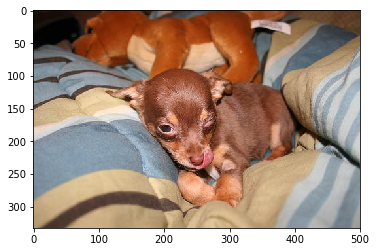

Image Test - Bounding box : 
--------------------------


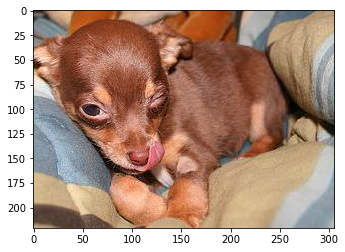

In [0]:
ind = 0

print("Image Test initiale : ")
print("--------------------")
img = cv.imread(image_Test[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

print("Image Test - Bounding box : ")
print("--------------------------")
img = cv.imread(image_Test_bounding_box_crop[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


--------------------

## 2.4 Création de matrices Train et Test (pour CNN et ImageDataGenerator Keras)



In [0]:
# Fonction de transformation des images en matrices et resizing
from PIL import Image

width = 224
STANDARD_SIZE = (width, width)

def img_to_matrix(filename, verbose=False):

    img = Image.open(filename)
    img = img.resize(STANDARD_SIZE)
    img = np.array(img)

    return img


In [0]:
# Création des matrices images pour CNN

data_Train = []
for image in image_2class_Train_tot :
    img = img_to_matrix(image)
    data_Train.append(img)

data_Train = np.array(data_Train)
print(data_Train.shape)
print(data_Train)
print()



(1000, 224, 224, 3)
[[[[ 30  23   5]
   [ 30  23   5]
   [ 30  23   5]
   ..., 
   [ 65  49  13]
   [ 65  49  13]
   [ 65  49  13]]

  [[ 30  23   5]
   [ 30  23   5]
   [ 30  23   5]
   ..., 
   [ 65  49  13]
   [ 65  49  13]
   [ 65  49  13]]

  [[ 30  23   5]
   [ 30  23   5]
   [ 30  23   5]
   ..., 
   [ 65  49  13]
   [ 65  49  13]
   [ 65  49  13]]

  ..., 
  [[105 118 101]
   [113 126 109]
   [123 136 118]
   ..., 
   [ 99 122 104]
   [112 135 117]
   [ 97 120 102]]

  [[110 121 113]
   [115 128 119]
   [121 134 124]
   ..., 
   [ 99 121 109]
   [ 93 115 103]
   [ 79 101  89]]

  [[116 130 131]
   [118 132 133]
   [116 132 132]
   ..., 
   [ 92 113 108]
   [ 85 106 101]
   [ 95 116 111]]]


 [[[120  98 101]
   [121  99 102]
   [121  99 102]
   ..., 
   [143 117 130]
   [137 112 118]
   [132 107 110]]

  [[121  99 102]
   [121  99 102]
   [122 100 103]
   ..., 
   [144 118 131]
   [138 113 119]
   [133 108 111]]

  [[122 100 103]
   [122 100 103]
   [123 101 104]
   ..., 
   [14

In [0]:
# Création des matrices images pour CNN

data_Train_box = []
for image in image_2class_Train_box :
    img = img_to_matrix(image)
    data_Train_box.append(img)

data_Train_box = np.array(data_Train_box)
print(data_Train_box.shape)
print(data_Train_box)
print()


(200, 224, 224, 3)
[[[[ 44  38  14]
   [ 44  38  14]
   [ 44  38  14]
   ..., 
   [ 15   4   2]
   [ 15   3   3]
   [ 14   2   2]]

  [[ 44  38  14]
   [ 44  38  14]
   [ 44  38  14]
   ..., 
   [ 15   5   3]
   [ 15   3   3]
   [ 15   3   3]]

  [[ 44  38  14]
   [ 44  38  14]
   [ 44  38  14]
   ..., 
   [ 16   8   5]
   [ 16   8   6]
   [ 16   8   6]]

  ..., 
  [[120 143 133]
   [120 143 133]
   [120 141 132]
   ..., 
   [119 107  81]
   [160 156 131]
   [165 169 144]]

  [[123 146 138]
   [126 149 141]
   [130 153 143]
   ..., 
   [100  85  62]
   [143 138 116]
   [172 176 153]]

  [[126 149 141]
   [130 153 145]
   [135 158 148]
   ..., 
   [ 93  78  57]
   [137 132 110]
   [176 179 158]]]


 [[[155 129 132]
   [155 129 132]
   [155 129 130]
   ..., 
   [166 137 142]
   [166 137 142]
   [166 137 142]]

  [[155 129 132]
   [155 129 132]
   [155 129 132]
   ..., 
   [166 137 142]
   [166 137 142]
   [166 137 142]]

  [[155 128 133]
   [155 128 133]
   [155 128 133]
   ..., 
   [166

In [0]:
# Création des matrices images pour CNN - Images Test standards

data_Test = []
for image in image_2class_Test :
    img = img_to_matrix(image)
    data_Test.append(img)

data_Test = np.array(data_Test)
print(data_Test.shape)
print(data_Test)

(137, 224, 224, 3)
[[[[ 29  12   4]
   [ 30  13   5]
   [ 31  14   6]
   ..., 
   [ 85  54  33]
   [ 77  49  27]
   [ 79  51  29]]

  [[ 28  14   5]
   [ 28  14   5]
   [ 29  15   6]
   ..., 
   [ 85  54  33]
   [ 83  55  33]
   [ 80  52  30]]

  [[ 27  14   5]
   [ 28  15   6]
   [ 28  15   6]
   ..., 
   [ 87  56  35]
   [ 86  58  36]
   [ 81  53  31]]

  ..., 
  [[176 151 111]
   [177 152 111]
   [178 153 112]
   ..., 
   [157 157 157]
   [155 157 156]
   [153 155 154]]

  [[176 151 111]
   [176 151 110]
   [175 150 109]
   ..., 
   [157 157 157]
   [154 156 155]
   [153 155 154]]

  [[176 151 111]
   [175 150 109]
   [170 145 104]
   ..., 
   [156 156 156]
   [154 156 155]
   [152 154 153]]]


 [[[ 87  85  90]
   [ 86  84  89]
   [ 86  84  89]
   ..., 
   [136  22  74]
   [168  14  76]
   [180   3  71]]

  [[ 87  85  90]
   [ 86  84  89]
   [ 85  83  88]
   ..., 
   [228 120 169]
   [169  24  81]
   [173   8  68]]

  [[ 80  78  81]
   [ 80  78  81]
   [ 81  79  82]
   ..., 
   [175

In [0]:
# Création des matrices images pour CNN - Images Test "bounding box"
data_Test_box = []
for image in image_2class_Test_box :
    img = img_to_matrix(image)
    data_Test_box.append(img)

data_Test_box = np.array(data_Test_box)
print(data_Test_box.shape)
print(data_Test_box)

(137, 224, 224, 3)
[[[[ 68  40  18]
   [ 67  44  26]
   [ 60  41  27]
   ..., 
   [184 155 123]
   [185 156 124]
   [185 158 115]]

  [[ 66  39  18]
   [ 70  47  31]
   [ 65  47  33]
   ..., 
   [179 150 118]
   [178 149 117]
   [186 159 116]]

  [[ 75  50  30]
   [ 83  64  49]
   [ 83  67  54]
   ..., 
   [187 158 126]
   [186 157 125]
   [181 153 113]]

  ..., 
  [[174 148 121]
   [174 148 121]
   [173 147 120]
   ..., 
   [179 183 182]
   [183 185 184]
   [184 184 186]]

  [[189 162 132]
   [186 159 129]
   [184 157 127]
   ..., 
   [182 184 183]
   [183 183 181]
   [182 182 184]]

  [[198 172 139]
   [194 168 135]
   [191 165 132]
   ..., 
   [183 183 181]
   [182 182 180]
   [181 181 183]]]


 [[[ 14   9   6]
   [ 15  10   7]
   [ 17  12   9]
   ..., 
   [118 111 119]
   [103  96 104]
   [ 92  85  93]]

  [[ 40  35  32]
   [ 40  35  32]
   [ 40  35  32]
   ..., 
   [116 109 117]
   [105  98 106]
   [ 95  88  96]]

  [[ 47  42  39]
   [ 47  42  39]
   [ 48  43  40]
   ..., 
   [111

### Sauvegarde des matrices Train et Test

In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Train.py", "wb") as fp:   #Pickling
    pickle.dump(data_Train, fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Train_box.py", "wb") as fp:   #Pickling
    pickle.dump(data_Train_box, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Test.py", "wb") as fp:   #Pickling
    pickle.dump(data_Test, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Test_box.py", "wb") as fp:   #Pickling
    pickle.dump(data_Test_box, fp)


---------


## 2.5 Image augmentation Train via Keras (matrices - ImageDataGenerator)




In [0]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Train.py", "rb") as fp:   # Unpickling
    data_Train = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/data_Test.py", "rb") as fp:   # Unpickling
    data_Test = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Train_tot.py", "rb") as fp:   # Unpickling
    y_2class_Train_tot = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Test.py", "rb") as fp:   # Unpickling
    y_2class_Test = pickle.load(fp)

----

### Configuration du ImageDataGenerator


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Création et configuration du "augmented image generator"

train_datagen = ImageDataGenerator(  
    # featurewise_center=True,
    # samplewise_center=True,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    # zca_whitening=True,
    # zca_epsilon=1e-6,
    # rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.1,
    # channel_shift_range=0.,
    # fill_mode='nearest',
    # cval=0.,
    # horizontal_flip=False,
    # vertical_flip=False,
    rescale=1.0
    # preprocessing_function=None
    )

# fit augmented image generator
train_datagen.fit(data_Train)



----

### Création des images augmentées


In [0]:
img_width ,img_height = width, width
batch_size = 1
batches = 0
X_Train_augm = []
y_Train_augm = []


for x_batch, y_batch in train_datagen.flow(data_Train, y_2class_Train_tot, batch_size=batch_size) :
#                                            save_to_dir = augmented_dir, batch_size=batch_size) :
    X_Train_augm.append(x_batch[0])
    y_Train_augm.append(y_batch[0])
    
    batches += 1
    if batches >= len(data_Train) * 1 :
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break    


--------------


### Stockage des images augmentées


In [0]:
print(len(data_Train))

X_Train_augm = np.array(X_Train_augm)
y_Train_augm = np.array(y_Train_augm)

print(X_Train_augm.shape)
print(y_Train_augm.shape)

1000
(1000, 224, 224, 3)
(1000,)


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/X_Train_augm.py", "wb") as fp:   #Pickling
    pickle.dump(X_Train_augm, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/y_Train_augm.py", "wb") as fp:   #Pickling
    pickle.dump(y_Train_augm, fp)